In [20]:
# -*- coding: utf-8 -*-
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, transpiler
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.visualization import timeline_drawer
from qiskit.visualization.timeline import draw, IQXSimple, IQXStandard

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# For data fitting
from lmfit import Model

In [2]:
provider = IBMQ.enable_account('51057eaa66f88664f054b9a73766c53de4859a3e97c7f912cd975db51e3c9f67f9207c2833555417a8af276f7109783931401df61da2a785d595e8f429ce4309')
#provider = IBMQ.load_account()

In [3]:
backend = provider.get_backend('ibmq_lima')
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

## Get gates duration
https://qiskit.org/documentation/stubs/qiskit.transpiler.InstructionDurations.get.html
https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.

In [6]:
# Get duration of instructions

dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",0)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",3)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",0)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",1)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",1)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",1)
Measurement_duration3 = transpiler.InstructionDurations.from_backend(backend).get("measure",3)

CNOT_durations = [] # Will be in dt units
for pair in backend.configuration().coupling_map:
    CNOT_pair_duration = transpiler.InstructionDurations.from_backend(backend).get("cx",pair)
    CNOT_durations.append([str(pair),CNOT_pair_duration])
CNOT_durations = dict(CNOT_durations)

tau_cnot01 = CNOT_durations["[0, 1]"]
tau_cnot10 = CNOT_durations["[1, 0]"]
tau_cnot34 = CNOT_durations["[3, 4]"]
tau_cnot43 = CNOT_durations["[4, 3]"]
tau_cnot13 = CNOT_durations["[1, 3]"]

## Define the circuit creation functions

In [7]:
def build_sequence_circuit(num_gates, sequence="I only", qubit=0):
    
    q = QuantumRegister(5, 'q')
    circuit = QuantumCircuit(q)

    if sequence == "I only":   
        
        circuit.barrier(qubit)
        for i in range(num_gates):
            circuit.id(qubit)
            circuit.barrier(qubit)
            
    elif sequence == "Z only":
        
        circuit.barrier(qubit)
        for i in range(num_gates):
            circuit.z(qubit)
            circuit.barrier(qubit)
            
    if sequence == "D only":   
        
        circuit.barrier(qubit)
        for i in range(num_gates):
            circuit.delay(1, qubit, "dt")
            circuit.barrier(qubit)
    
    elif sequence == "ZIZI":
        
        num_blocks = num_gates//4 # Number of ZIZI blocks
        #if num_pairs%2 != 0: # Make sure that it is even
        #    num_pairs -= 1
            
        circuit.barrier(qubit)
        for i in range(num_blocks):
            circuit.z(qubit)
            circuit.barrier(qubit)
            circuit.id(qubit)
            circuit.barrier(qubit)
            circuit.z(qubit)
            circuit.barrier(qubit)
            circuit.id(qubit)
            circuit.barrier(qubit)
            
        num_gates = num_blocks*4
    
    elif sequence == "ZDZD":
        
        num_blocks = num_gates//4 # Number of ZDZD blocks
        circuit.barrier(qubit)
        for i in range(num_blocks):
            circuit.z(qubit)
            circuit.barrier(qubit)
            circuit.delay(1, qubit, "dt")
            circuit.barrier(qubit)
            circuit.z(qubit)
            circuit.barrier(qubit)
            circuit.delay(1, qubit, "dt")
            circuit.barrier(qubit)
        
        num_gates = num_blocks*4
            
    return circuit, num_gates
    
            
def build_main_circuit(sequence_circuit, qubit=0):
    
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(1, 'c')
    circuit = QuantumCircuit(q, c)
    
    circuit.h(qubit)
    circuit = circuit.compose(sequence_circuit, q) # https://www.youtube.com/watch?v=3ja8uCqUS0s
                                                   # https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.compose.html#qiskit.circuit.QuantumCircuit.compose
    circuit.h(qubit)
    circuit.measure(qubit,c)
    
    return circuit
    

**Circuit building settings.**

In [9]:
min_gates = 0
max_gates = 1000
num_steps = 100
step_size = (max_gates - min_gates)//num_steps

qubit = 0 # Set the qubit to be used

## Build the circuits

In [10]:
circuits = []
num_gates_list = [[], [], [], [], []]
gate_sequences = ["I only", "Z only", "ZIZI", "ZDZD", "D only"] 

for i, gate_sequence in enumerate(gate_sequences):
    for num_gates in range(min_gates, max_gates+step_size, step_size):
        sequence_circuit, num_gates_sequence = build_sequence_circuit(num_gates, sequence=gate_sequence, qubit=qubit)
        num_gates_list[i].append(num_gates_sequence)
        circuit = build_main_circuit(sequence_circuit, qubit=qubit)
        circuits.append(circuit)

**Transpile the circuits.**

In [11]:
transpiled_circuits = transpile(circuits, backend=backend, scheduling_method='asap', optimization_level=0)

**Check that the built circuits are correct.**

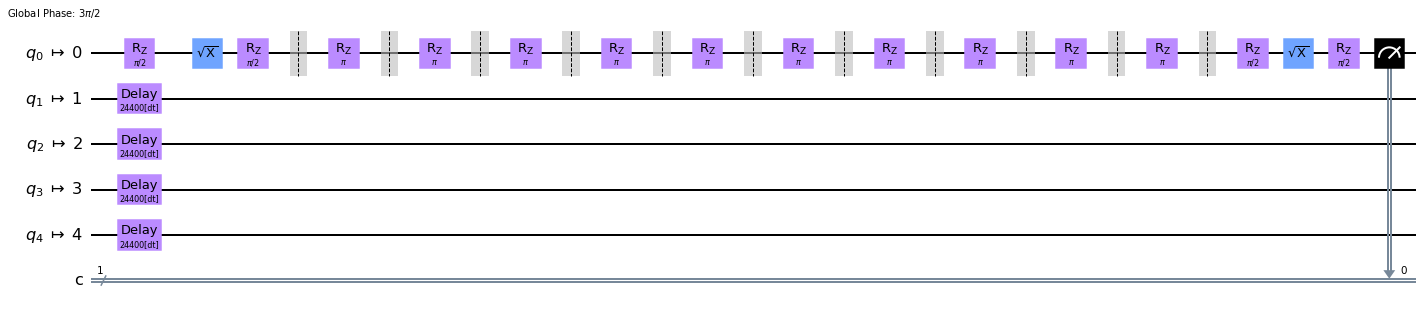

In [18]:
transpiled_circuits[102].draw("mpl", fold=-1)

### Plot a circuit schedule to check.

In [21]:
# Instruction durations for the schedule plot

durations = InstructionDurations(
    [("h", 1, H_duration), 
     ("x", 0, X_duration), 
     ("x", 1, X_duration), 
     ("x", 2, X_duration), 
     ("x", 3, X_duration), 
     ("x", 4, X_duration), 
     ("z", 0, Z_duration), 
     ("z", 1, Z_duration), 
     ("z", 2, Z_duration), 
     ("z", 3, Z_duration), 
     ("z", 4, Z_duration),
     ("id", 0, I_duration),
     ("id", 1, I_duration),
     ("id", 2, I_duration),
     ("id", 3, I_duration),
     ("id", 4, I_duration),
     ("cx", [0, 1], CNOT_durations["[0, 1]"]), 
     ("cx", [1, 0], CNOT_durations["[1, 0]"]),
     ("cx", [1, 3], CNOT_durations["[1, 3]"]),
     ("cx", [3, 4], CNOT_durations["[3, 4]"]),
     ("cx", [4, 3], CNOT_durations["[4, 3]"]),
     ("reset", None, Reset_duration),
     ("measure", None, Measurement_duration)]
)

pm = PassManager([ALAPSchedule(durations)])

In [34]:
# Style for the schedule plot

# https://matplotlib.org/3.5.0/users/prev_whats_new/dflt_style_changes.html
# https://qiskit.org/documentation/stubs/qiskit.visualization.timeline_drawer.html
# https://github.com/Qiskit/qiskit-terra/pull/5063/files/5fa5898bad0a53da23c0daa61f2d99c7e822de1b#diff-4ad47bcead055d747c1ef626ff0baece4907ef6e8ee6a227c9df53459ca9ea86

my_style = {
    "formatter.latex_symbol.frame_change" : r"\,",
    'formatter.general.fig_width': 20,
    #"formatter.unicode_symbol.frame_change" : "",
    #"formatter.layer.frame_change" : 0,
    #"formatter.text_size.frame_change":0,
    #"formatter.alpha.gates":0,
    "formatter.text_size.gate_name": 14,
    "formatter.time_bucket.edge_dt": 100,
    "formatter.latex_symbol.gates":
        {
        'rz': r'\,',
        'x': r'\,',
        'sx': r'\,',
        'id': r'\,',
        'reset': r'|0\rangle',
        'measure': r'{\rm Measure}'
        },
    "formatter.color.gates":
        {
        'cx': '#6FA4FF',
        'x': '#DC143C', # Red
        'sx': '#6FA4FF', # Blue
        'reset': '#a0a0a0', # Gray
        'measure': '#a0a0a0' #'#808080',
        #'delay': '#1E90FF'
        }
}

style = IQXStandard(**my_style)

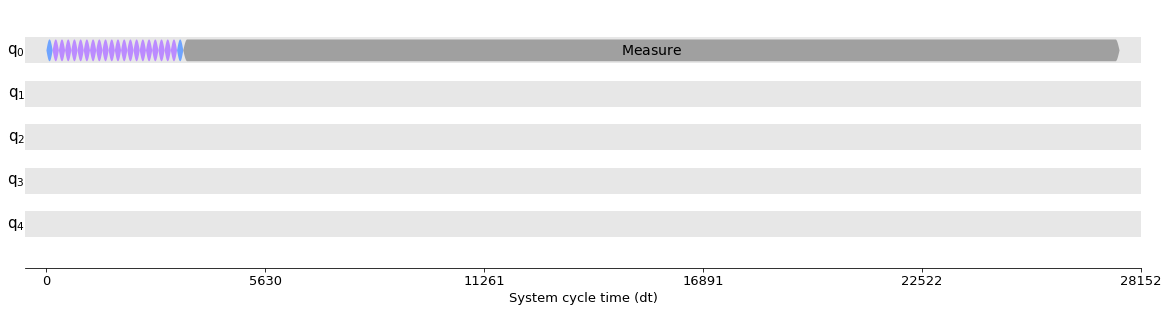

In [36]:
sample_circuit = transpiled_circuits[2]
timeline_drawer(sample_circuit, style=style, show_barriers=False)#, show_delays=True)

## Send the job set to IBM

In [13]:
job_manager = IBMQJobManager()
cname = 'ZgatesTest-8192shots-100steps-q0' # or q4
job = job_manager.run(transpiled_circuits, backend=backend, name=cname, shots=8192) # 2**13 shots

**For saving the job_set id for being able to retrieve it in the future.**

In [ ]:
job_set_id = job.job_set_id()
print(job_set_id)

**For checking the job status.**

In [ ]:
job.statuses()

## Get the job results

In [19]:
# to get 5 sequences
#job_manager = IBMQJobManager()
#job = job_manager.retrieve_job_set("job_set-id-here", provider)

result = job.results().combine_results()
counts = result.get_counts()
data_0 = [count["0"] for count in counts]

**Order the data.**

In [12]:
def separate_cases(cases, num_steps):
    return [[cases[i] for i in range((j-1)*(num_steps+1), j*(num_steps+1))] for j in range(1,6)]

In [ ]:
data_I, data_Z, data_ZIZI, data_ZDZD, data_D = separate_cases(data_0, num_steps)

## Plot the results

### Qubit 0
**Without data fitting:**

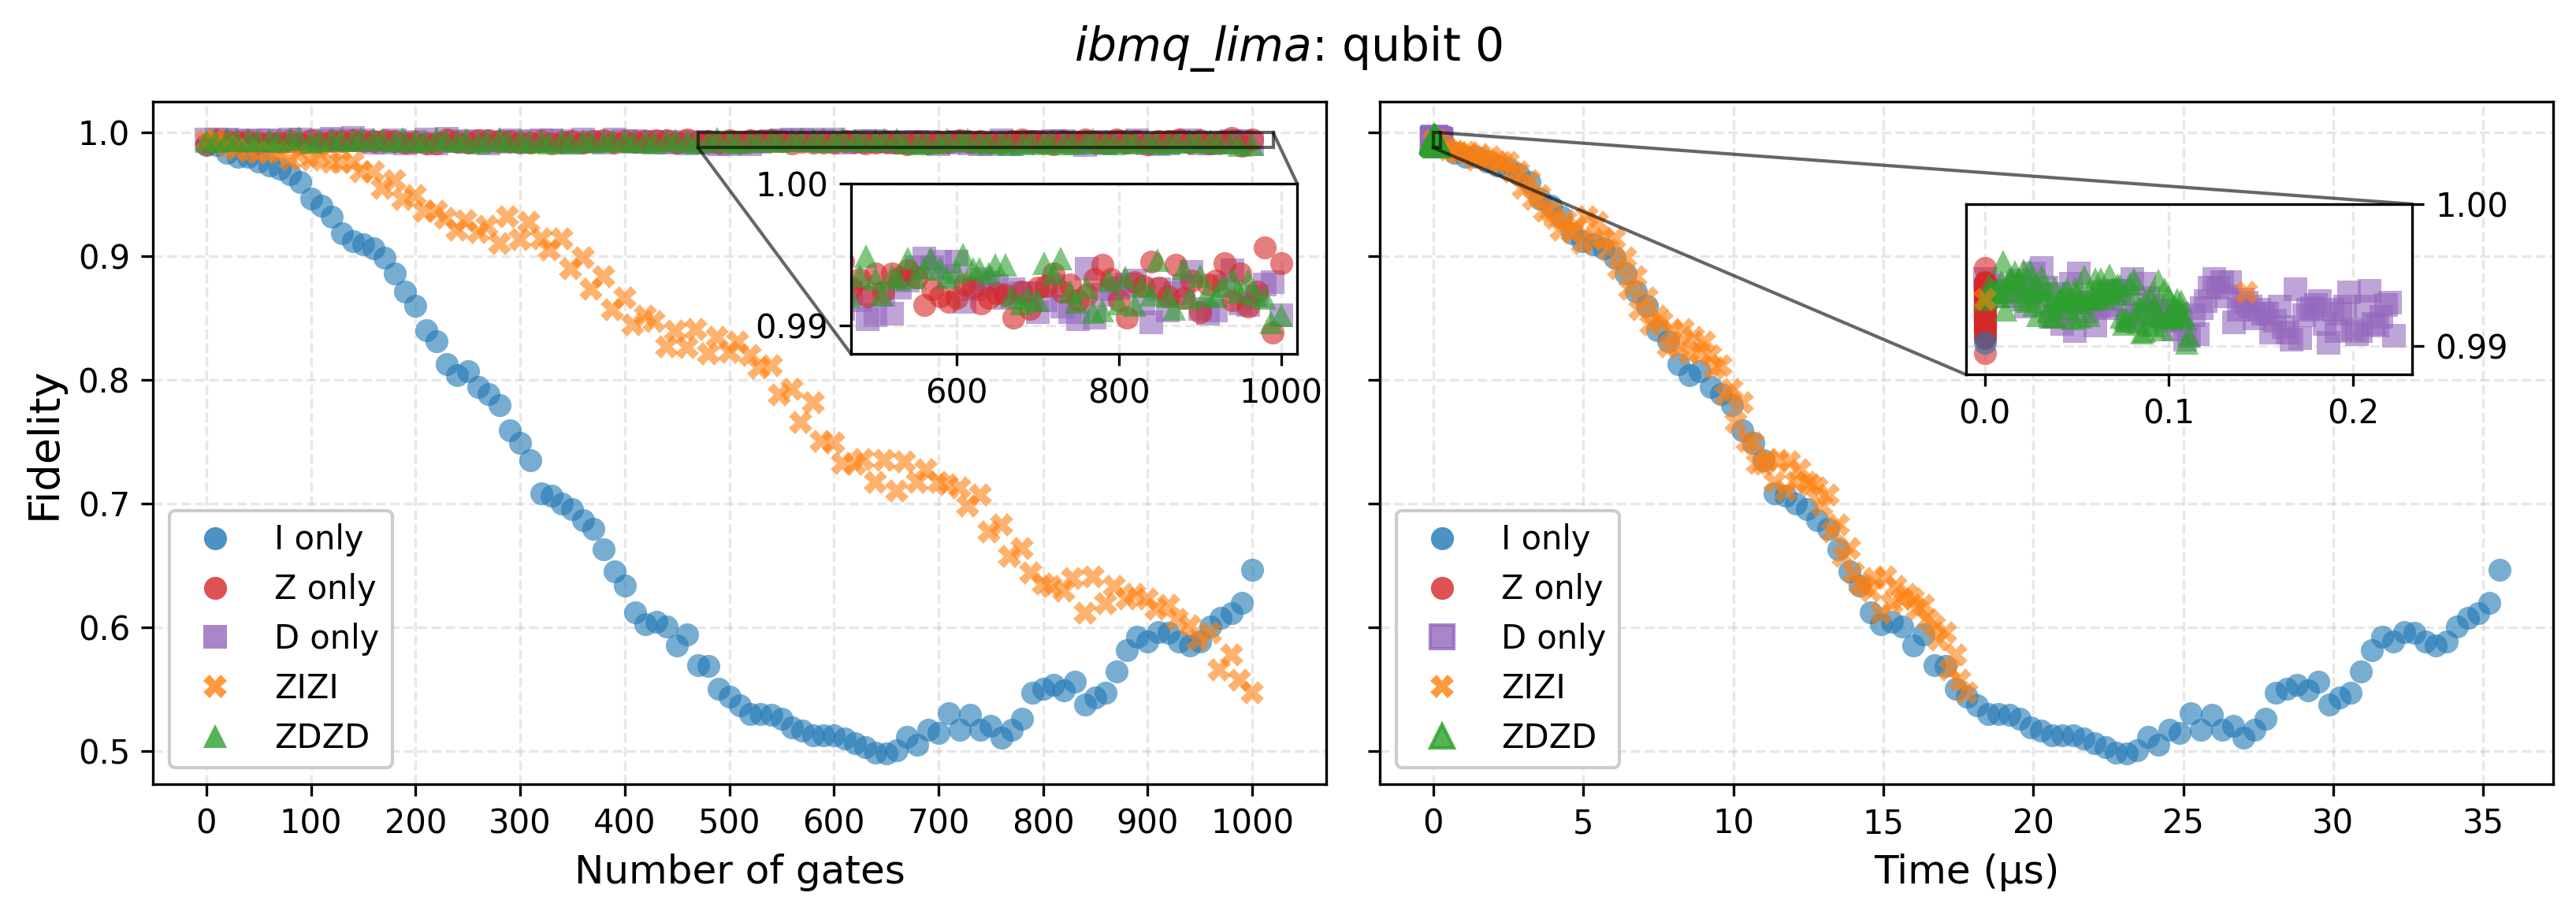

In [21]:
x      = np.arange(min_gates, max_gates+step_size, step_size)
xticks = np.arange(min_gates, max_gates+10*step_size, 10*step_size, dtype=int)
shots = 8192
a = 0.6 # Alpha
ms = 7 # Markersize

fig, axs = plt.subplots(ncols=2, figsize=(11,4), sharey=True, dpi=300)
fig.suptitle(r"$\it{ibmq\_%s}$: qubit 0" % "lima", y=0.955, fontsize=14)

# Number of gates plot --------------------

ax = axs[0]
ax.set_xticks(xticks)
ax.set_xlabel("Number of gates", fontsize=12)
ax.set_ylabel(r"Fidelity", fontsize=13)

# Plot the points
ax.plot(num_gates_list[0],np.asarray(data_I)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="I only", alpha=a, c="C0")
ax.plot(num_gates_list[1],np.asarray(data_Z)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="Z only", alpha=a, c="C3")
ax.plot(num_gates_list[1],np.asarray(data_D)/shots, lw=0, marker="s", markersize=ms, markeredgewidth=0, label="D only", alpha=a, ls="--", c="C4", zorder=1)
ax.plot(num_gates_list[2],np.asarray(data_ZIZI)/shots, lw=0, marker="X", markersize=ms, markeredgewidth=0, label="ZIZI", alpha=a, ls="--", c="C1")
ax.plot(num_gates_list[3],np.asarray(data_ZDZD)/shots, lw=0, marker="^", markersize=ms, markeredgewidth=0, label="ZDZD", alpha=a, ls="--", c="C2")

# Inset axes
axins = ax.inset_axes([0.595, 0.63, 0.38, 0.25])
axins.plot(num_gates_list[0],np.asarray(data_I)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="I only", alpha=a, c="C0")
axins.plot(num_gates_list[1],np.asarray(data_Z)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="Z only", alpha=a, c="C3")
axins.plot(num_gates_list[1],np.asarray(data_D)/shots, lw=0, marker="s", markersize=ms, markeredgewidth=0, label="D only", alpha=a, ls="--", c="C4", zorder=1)
axins.plot(num_gates_list[2],np.asarray(data_ZIZI)/shots, lw=0, marker="X", markersize=ms, markeredgewidth=0, label="ZIZI", alpha=a, ls="--", c="C1")
axins.plot(num_gates_list[3],np.asarray(data_ZDZD)/shots, lw=0, marker="^", markersize=ms, markeredgewidth=0, label="ZDZD", alpha=a, ls="--", c="C2")

axins.set_xlim(470, 1020)
axins.set_ylim(0.988, 1.)
#axins.yaxis.tick_right()
axins.grid(ls="--", alpha=0.3)
ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.6)

leg = ax.legend(loc="best", framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
ax.grid(ls="--", alpha=0.3)

# Time plot --------------------

ax2 = axs[1]
ax2.set_xlabel("Time (μs)", fontsize=12)

# Plot the points
ax2.plot(np.asarray(num_gates_list[0])*I_duration*dt_in_s*1e6,np.asarray(data_I)/shots, 
         lw=0, marker="o", markersize=ms, label="I only", alpha=a, c="C0", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[1])*0*dt_in_s*1e6,np.asarray(data_Z)/shots, 
         lw=0, marker="o", markersize=ms, label="Z only", alpha=a, c="C3", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[1])*1*dt_in_s*1e6,np.asarray(data_D)/shots, 
         lw=0, marker="s", markersize=ms, label="D only", alpha=a, ls="--", c="C4")
ax2.plot(np.asarray(num_gates_list[2])*I_duration/2*dt_in_s*1e6,np.asarray(data_ZIZI)/shots, 
         lw=0, marker="X", markersize=ms, label="ZIZI", alpha=a, ls="--", c="C1", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[3])*1/2*dt_in_s*1e6,np.asarray(data_ZDZD)/shots, 
         lw=0, marker="^", markersize=ms, label="ZDZD", alpha=a, ls="--", c="C2")

# Inset axes
axins = ax2.inset_axes([0.5, 0.6, 0.38, 0.25])

axins.plot(np.asarray(num_gates_list[0])*I_duration*dt_in_s*1e6,np.asarray(data_I)/shots, 
         lw=0, marker="o", markersize=ms, label="I only", alpha=a, c="C0", zorder=30, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[1])*0*dt_in_s*1e6,np.asarray(data_Z)/shots, 
         lw=0, marker="o", markersize=ms, label="Z only", alpha=a, c="C3", markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[1])*1*dt_in_s*1e6,np.asarray(data_D)/shots, 
         lw=0, marker="s", markersize=ms, label="D only", alpha=a, ls="--", c="C4", zorder=0, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[2])*I_duration/2*dt_in_s*1e6,np.asarray(data_ZIZI)/shots, 
         lw=0, marker="X", markersize=ms, label="ZIZI", alpha=a, ls="--", c="C1", zorder=30, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[3])*1/2*dt_in_s*1e6,np.asarray(data_ZDZD)/shots, 
         lw=0, marker="^", markersize=ms, label="ZDZD", alpha=a, ls="--", c="C2", markeredgewidth=0)

axins.set_xlim(-0.01, np.asarray(num_gates_list[3])[-1]*1*dt_in_s*1e6+0.01)
axins.set_ylim(0.988, 1)
axins.yaxis.tick_right()
axins.grid(ls="--", alpha=0.3)
ax2.indicate_inset_zoom(axins, edgecolor="black", alpha=0.6)

leg = ax2.legend(loc="lower left", framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
ax2.grid(ls="--", alpha=0.3)

plt.tight_layout()
plt.show()
#plt.savefig(r"lima_numGates_time_q0_12082022.pdf")

**With data fitting:**

0 0 <Parameter 'T', value=699.594893696214 +/- 44.7, bounds=[-inf:inf]> <Parameter 'B', value=0.3615718468767428 +/- 0.00803, bounds=[-inf:inf]> <Parameter 'C', value=0.0007753787857806504 +/- 1.04e-05, bounds=[-inf:inf]> <Parameter 'D', value=-0.33338045344979544 +/- 0.0433, bounds=[-inf:inf]> <Parameter 'E', value=0.6422802150994982 +/- 0.00477, bounds=[-inf:inf]>
True
0 3 <Parameter 'T', value=1926.7587171524747 +/- 3.72e+03, bounds=[-inf:inf]> <Parameter 'B', value=0.3533592237402101 +/- 0.285, bounds=[-inf:inf]> <Parameter 'C', value=0.0003333952606421052 +/- 8.46e-05, bounds=[-inf:inf]> <Parameter 'D', value=-0.1594218810436553 +/- 0.662, bounds=[-inf:inf]> <Parameter 'E', value=0.6424102055766804 +/- 0.248, bounds=[-inf:inf]>
True
0 1 <Parameter 'A', value=-1.1858665186396443e-07 +/- 3.6e-07, bounds=[-inf:inf]> <Parameter 'B', value=0.9927906709558666 +/- 0.000208, bounds=[-inf:inf]>

0 2 <Parameter 'A', value=-2.0003321563817695e-06 +/- 3.71e-07, bounds=[-inf:inf]> <Parameter '

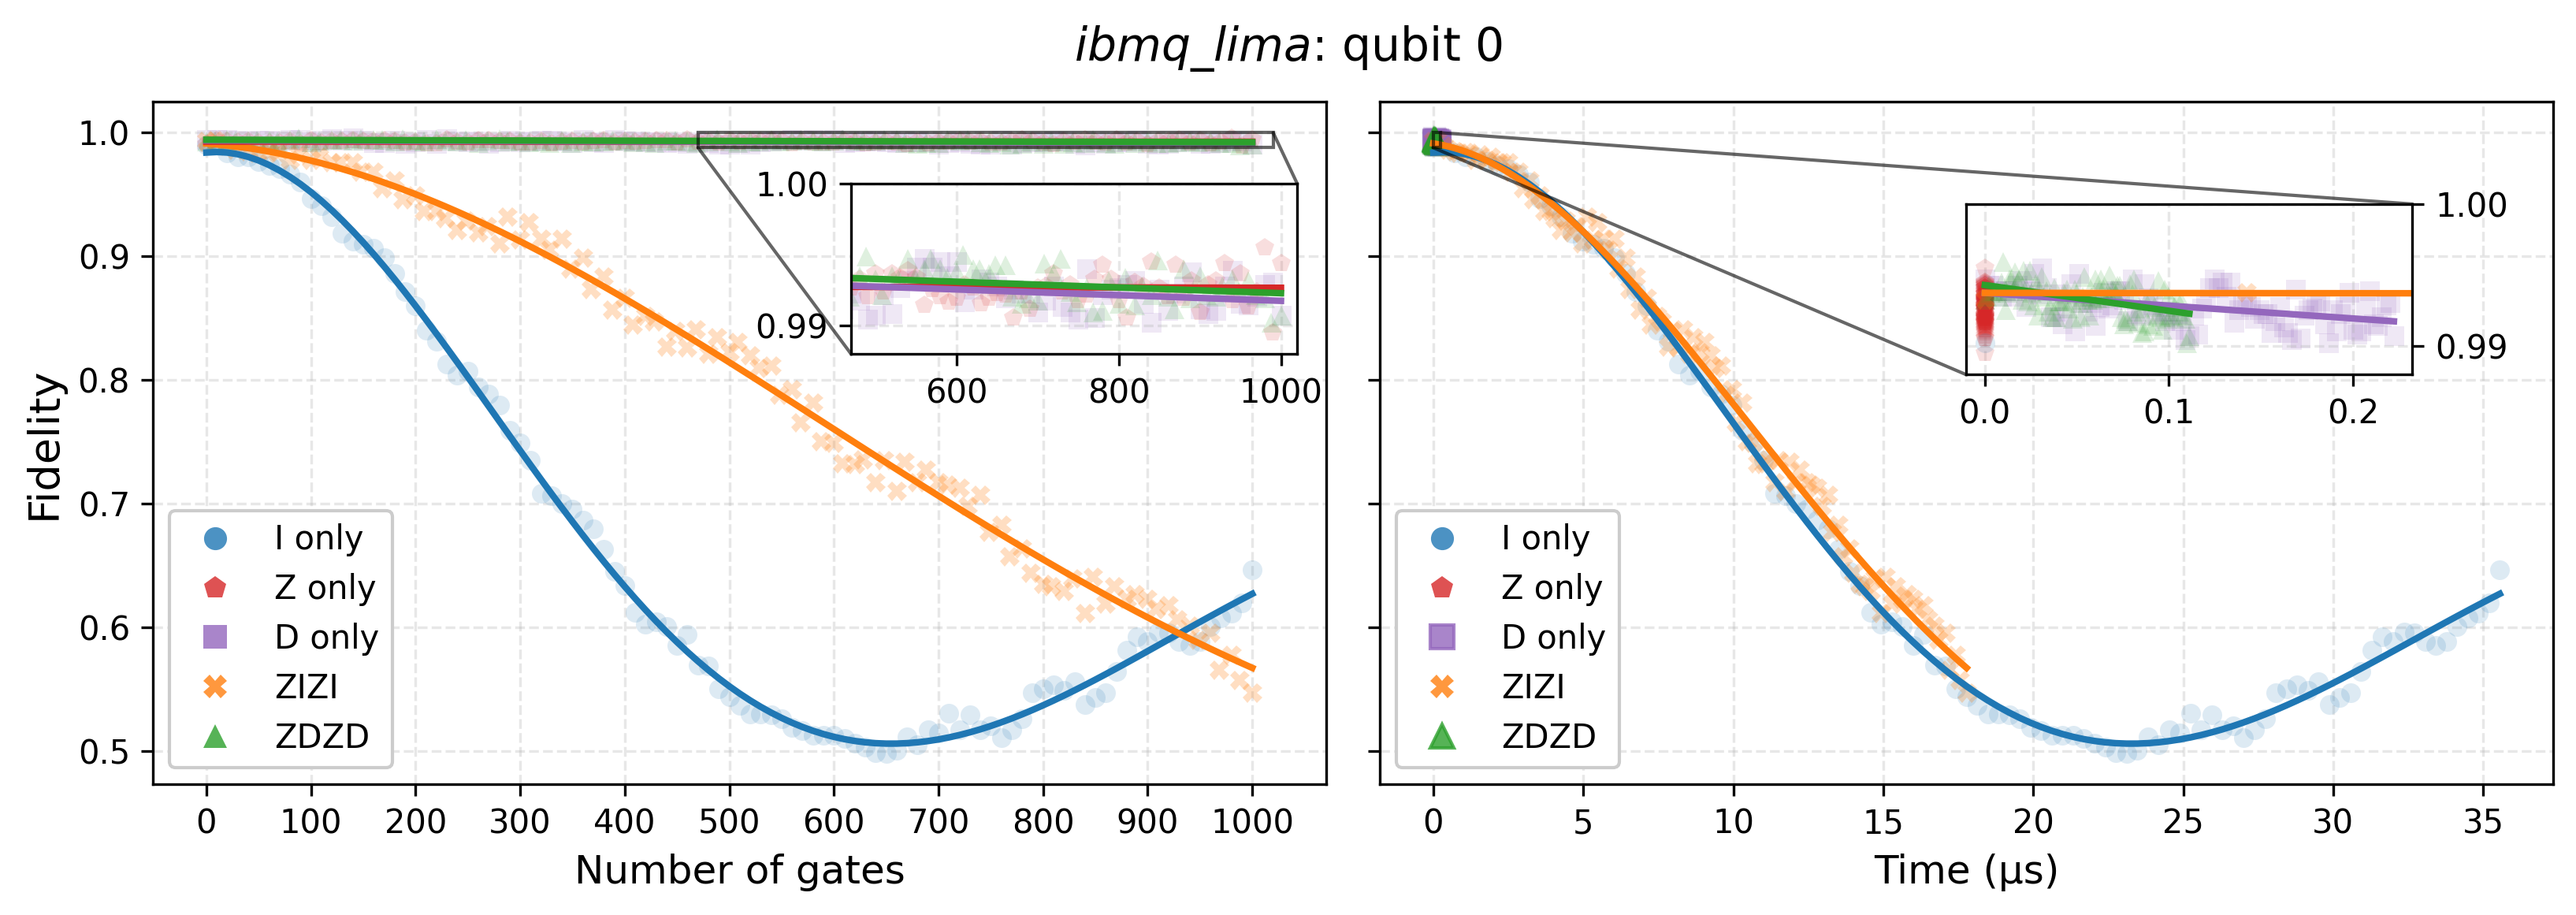

In [22]:
import copy

def line_fit(x, A, B):
    return A*x + B

def cos_ramsey(x, T, B, C, D, E):
    # https://qiskit.org/documentation/experiments/tutorials/t2ramsey_characterization.html
    return B*np.exp(-x/T)*np.cos(2*np.pi*C*x+D) + E# + phi) + B

x      = np.arange(min_gates, max_gates+step_size, step_size)
xticks = np.arange(min_gates, max_gates+10*step_size, 10*step_size, dtype=int)
shots = 8192
a = 0.15 # Alpha
ms = 6 # Markersize
colors = ["C0", "C3", "C4", "C1", "C2"]

fig, axs = plt.subplots(ncols=2, figsize=(11,4), sharey=True, dpi=300)
fig.suptitle(r"$\it{ibmq\_%s}$: qubit 0" % "lima", y=0.955, fontsize=14)

# Number of gates plot --------------------

ax = axs[0]
ax.set_xticks(xticks)
ax.set_xlabel("Number of gates", fontsize=12)
ax.set_ylabel("Fidelity", fontsize=13)

# Plot the points
ax.plot(num_gates_list[0],np.asarray(data_I)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="I only", alpha=a, c="C0")
ax.plot(num_gates_list[1],np.asarray(data_Z)/shots, lw=0, marker="p", markersize=ms, markeredgewidth=0, label="Z only", alpha=a, c="C3")
ax.plot(num_gates_list[1],np.asarray(data_D)/shots, lw=0, marker="s", markersize=ms, markeredgewidth=0, label="D only", alpha=a, ls="--", c="C4", zorder=1)
ax.plot(num_gates_list[2],np.asarray(data_ZIZI)/shots, lw=0, marker="X", markersize=ms, markeredgewidth=0, label="ZIZI", alpha=a+0.1, ls="--", c="C1")
ax.plot(num_gates_list[3],np.asarray(data_ZDZD)/shots, lw=0, marker="^", markersize=ms, markeredgewidth=0, label="ZDZD", alpha=a, ls="--", c="C2")

# Plot the fits
fidelities = [np.asarray(data_I)/shots, 
              np.asarray(data_Z)/shots, 
              np.asarray(data_D)/shots, 
              np.asarray(data_ZIZI)/shots, 
              np.asarray(data_ZDZD)/shots]
fit_curves = []
fit_results =[]

for l, k in enumerate([0,3]):
    seq_data = fidelities[k]
    seq_num_gates = num_gates_list[[0,1,1,2,3][k]]

    if k == 3:
        seq_num_gates = seq_num_gates
        
    model = Model(cos_ramsey)
    model.set_param_hint('T', value=1000)#, min=0)
    model.set_param_hint('B', value=1)
    model.set_param_hint('C', value=0.0001)
    model.set_param_hint('D', value=1)
    model.set_param_hint('E', value=0.5)
    fit_result = model.fit(seq_data, x=seq_num_gates) 
    print(0, k, fit_result.params["T"], 
         fit_result.params["B"],
         fit_result.params["C"],
         fit_result.params["D"],
         fit_result.params["E"])
    print(fit_result.success)
    plot_y = fit_result.best_fit
    fit_curves.append(np.copy(plot_y))
    fit_results.append(copy.copy(fit_result))
    
    if k==3:
        new_y = cos_ramsey(x=np.asarray(num_gates_list[[0,1,1,2,3][k]]), 
           T=fit_result.params["T"].value, 
           B=fit_result.params["B"].value, 
           C=fit_result.params["C"].value, 
           D=fit_result.params["D"].value, 
           E=fit_result.params["E"].value)
        ax.plot(num_gates_list[[0,1,1,2,3][k]], new_y, lw=2, alpha=1, ls="solid", c="C1")
    else:
        ax.plot(seq_num_gates, plot_y, lw=2, alpha=1, ls="solid", c=colors[k])
    
# Inset axes
axins = ax.inset_axes([0.595, 0.63, 0.38, 0.25])
axins.plot(num_gates_list[0],np.asarray(data_I)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="I only", alpha=a, c="C0")
axins.plot(num_gates_list[1],np.asarray(data_Z)/shots, lw=0, marker="p", markersize=ms, markeredgewidth=0, label="Z only", alpha=a, c="C3")
axins.plot(num_gates_list[1],np.asarray(data_D)/shots, lw=0, marker="s", markersize=ms, markeredgewidth=0, label="D only", alpha=a, ls="--", c="C4", zorder=1)
axins.plot(num_gates_list[2],np.asarray(data_ZIZI)/shots, lw=0, marker="X", markersize=ms, markeredgewidth=0, label="ZIZI", alpha=a+0.1, ls="--", c="C1")
axins.plot(num_gates_list[3],np.asarray(data_ZDZD)/shots, lw=0, marker="^", markersize=ms, markeredgewidth=0, label="ZDZD", alpha=a, ls="--", c="C2")

# Inset fits
for k in [1,2,4]:
    seq_data = fidelities[k]
    seq_num_gates = num_gates_list[[0,1,1,2,3][k]]

    model = Model(line_fit)
    model.set_param_hint('A', value=0)
    model.set_param_hint('B', value=1)
    fit_result = model.fit(seq_data, x=seq_num_gates) 
    print(0, k,
         fit_result.params["A"],
         fit_result.params["B"])
    print()
    plot_y = fit_result.best_fit
    fit_curves.append(np.copy(plot_y))
    ax.plot(seq_num_gates, plot_y, lw=2, alpha=1, ls="solid", c=colors[k])
    axins.plot(seq_num_gates, plot_y, lw=2, alpha=1, ls="solid", c=colors[k])
    
axins.set_xlim(470, 1020)
axins.set_ylim(0.988, 1.)
axins.grid(ls="--", alpha=0.3)
ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.6)

leg = ax.legend(loc="best", framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
    lh.set_markersize(7)
ax.grid(ls="--", alpha=0.3)

# Time plot --------------------

ax2 = axs[1]
ax2.set_xlabel("Time (μs)", fontsize=12)

# Plot the points
ax2.plot(np.asarray(num_gates_list[0])*I_duration*dt_in_s*1e6,np.asarray(data_I)/shots, 
         lw=0, marker="o", markersize=ms, label="I only", alpha=a, c="C0", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[1])*0*dt_in_s*1e6,np.asarray(data_Z)/shots, 
         lw=0, marker="p", markersize=ms, label="Z only", alpha=a, c="C3", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[1])*1*dt_in_s*1e6,np.asarray(data_D)/shots, 
         lw=0, marker="s", markersize=ms, label="D only", alpha=a, ls="--", c="C4")
ax2.plot(np.asarray(num_gates_list[2])*I_duration/2*dt_in_s*1e6,np.asarray(data_ZIZI)/shots, 
         lw=0, marker="X", markersize=ms, label="ZIZI", alpha=a+0.1, ls="--", c="C1", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[3])*1/2*dt_in_s*1e6,np.asarray(data_ZDZD)/shots, 
         lw=0, marker="^", markersize=ms, label="ZDZD", alpha=a, ls="--", c="C2")

# Plot the fits
times = [np.asarray(num_gates_list[0])*I_duration*dt_in_s*1e6,
        np.asarray(num_gates_list[1])*0*dt_in_s*1e6,
        np.asarray(num_gates_list[1])*1*dt_in_s*1e6,
        np.asarray(num_gates_list[2])*I_duration/2*dt_in_s*1e6,
        np.asarray(num_gates_list[3])*1/2*dt_in_s*1e6]

for k in [0,3]:
    seq_data = fidelities[k]
    seq_times = times[k]

    if k == 3:
        seq_times = seq_times
        
    model = Model(cos_ramsey)
    model.set_param_hint('T', value=1000, min=0)
    model.set_param_hint('B', value=1)
    model.set_param_hint('C', value=0.05)
    model.set_param_hint('D', value=0)
    model.set_param_hint('E', value=0.5)
    fit_result = model.fit(seq_data, x=seq_times) 
    print(0, k, fit_result.params["T"], 
         fit_result.params["B"],
         fit_result.params["C"],
         fit_result.params["D"],
         fit_result.params["E"])
    print()
    plot_y = fit_result.best_fit
    fit_curves.append(np.copy(plot_y))
    if k==3:
        new_y = cos_ramsey(x=times[3], 
           T=fit_result.params["T"].value, 
           B=fit_result.params["B"].value, 
           C=fit_result.params["C"].value, 
           D=fit_result.params["D"].value, 
           E=fit_result.params["E"].value)
        ax2.plot(times[k], new_y, lw=2, alpha=1, ls="solid", c="C1")
    else:
        ax2.plot(seq_times, plot_y, lw=2, alpha=1, ls="solid", c=colors[k])
    
# Inset axes
axins = ax2.inset_axes([0.5, 0.6, 0.38, 0.25])#[0.5, 0.55, 0.38, 0.38])

axins.plot(np.asarray(num_gates_list[0])*I_duration*dt_in_s*1e6,np.asarray(data_I)/shots, 
         lw=0, marker="o", markersize=ms, label="I only", alpha=a, c="C0", zorder=30, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[1])*0*dt_in_s*1e6,np.asarray(data_Z)/shots, 
         lw=0, marker="p", markersize=ms, label="Z only", alpha=a, c="C3", markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[1])*1*dt_in_s*1e6,np.asarray(data_D)/shots, 
         lw=0, marker="s", markersize=ms, label="D only", alpha=a, ls="--", c="C4", zorder=0, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[2])*I_duration/2*dt_in_s*1e6,np.asarray(data_ZIZI)/shots, 
         lw=0, marker="X", markersize=ms, label="ZIZI", alpha=a+0.1, ls="--", c="C1", zorder=30, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[3])*1/2*dt_in_s*1e6,np.asarray(data_ZDZD)/shots, 
         lw=0, marker="^", markersize=ms, label="ZDZD", alpha=a, ls="--", c="C2", markeredgewidth=0)

# Inset fits
for k in [2,4]:
    seq_data = fidelities[k]
    seq_times = times[k]

    model = Model(line_fit)
    model.set_param_hint('A', value=0)
    model.set_param_hint('B', value=1)
    fit_result = model.fit(seq_data, x=seq_times) 
    print(0, k, 
         fit_result.params["A"],
         fit_result.params["B"])
    print()
    plot_y = fit_result.best_fit
    fit_curves.append(np.copy(plot_y))
    axins.plot(seq_times, plot_y, lw=2, alpha=1, ls="solid", c=colors[k])
axins.plot(times[0], fit_curves[0], lw=2, alpha=1, ls="solid", c="C0")
axins.plot(times[3], fit_curves[3], lw=2, alpha=1, ls="solid", c="C1")
    
axins.set_xlim(-0.01, np.asarray(num_gates_list[3])[-1]*1*dt_in_s*1e6+0.01)
axins.set_ylim(0.988, 1)
axins.yaxis.tick_right()
axins.grid(ls="--", alpha=0.3)
ax2.indicate_inset_zoom(axins, edgecolor="black", alpha=0.6)

leg = ax2.legend(loc="lower left", framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
    lh.set_markersize(7)
ax2.grid(ls="--", alpha=0.3)

plt.tight_layout()
plt.show()
#plt.savefig(r"lima_numGates_time_q0_12082022_fit.pdf")

### Qubit 4
**Without data fitting:**

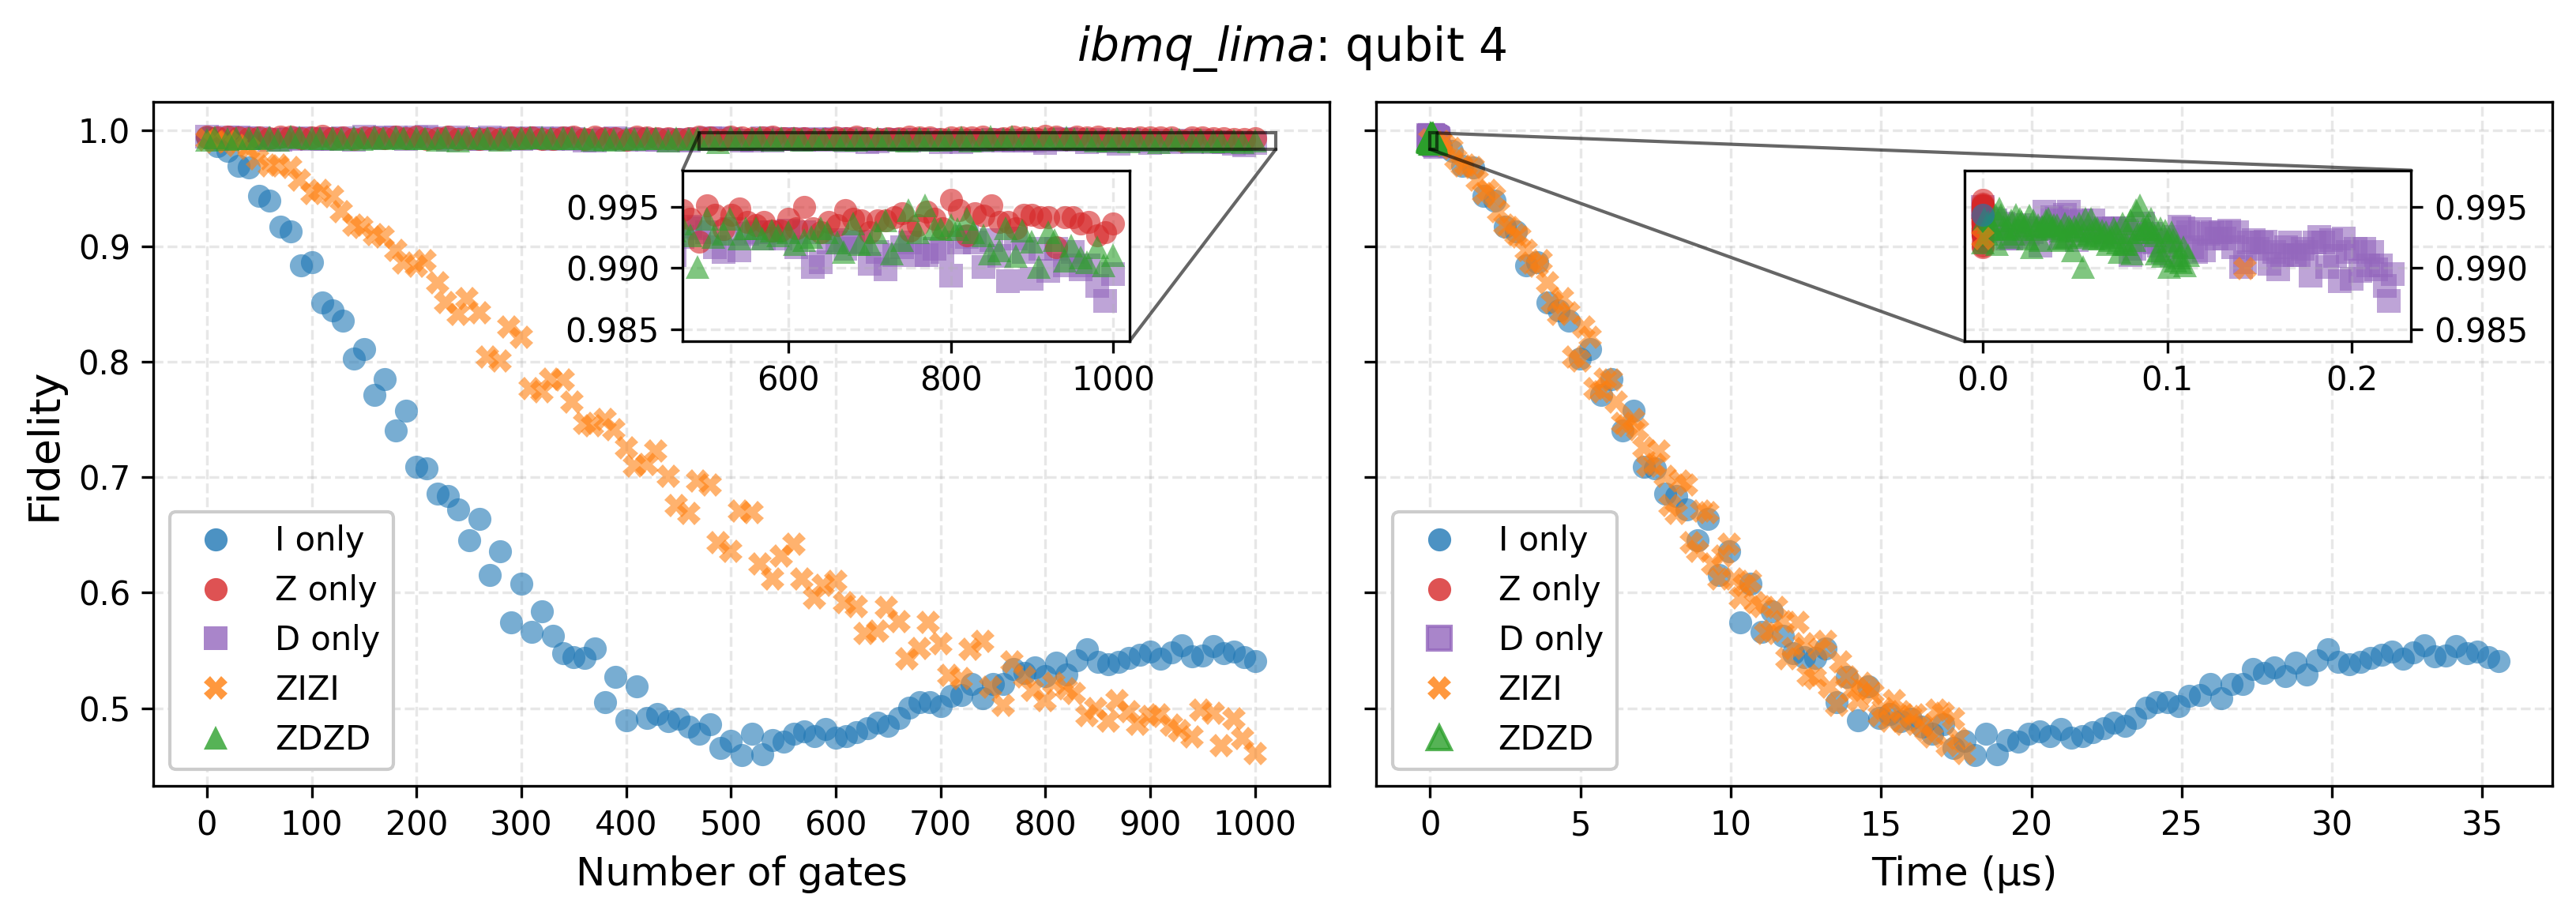

In [16]:
x      = np.arange(min_gates, max_gates+step_size, step_size)
xticks = np.arange(min_gates, max_gates+10*step_size, 10*step_size, dtype=int)
shots = 8192
a = 0.6 # Alpha
ms = 7 # Markersize

fig, axs = plt.subplots(ncols=2, figsize=(11,4), sharey=True, dpi=300)
fig.suptitle(r"$\it{ibmq\_%s}$: qubit 4" % "lima", y=0.955, fontsize=14)

# Number of gates plot --------------------

ax = axs[0]
ax.set_xticks(xticks)
ax.set_xlabel("Number of gates", fontsize=12)
ax.set_ylabel(r"Fidelity", fontsize=13)

# Plot the points
ax.plot(num_gates_list[0],np.asarray(data_I)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="I only", alpha=a, c="C0")
ax.plot(num_gates_list[1],np.asarray(data_Z)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="Z only", alpha=a, c="C3")
ax.plot(num_gates_list[1],np.asarray(data_D)/shots, lw=0, marker="s", markersize=ms, markeredgewidth=0, label="D only", alpha=a, ls="--", c="C4", zorder=1)
ax.plot(num_gates_list[2],np.asarray(data_ZIZI)/shots, lw=0, marker="X", markersize=ms, markeredgewidth=0, label="ZIZI", alpha=a, ls="--", c="C1")
ax.plot(num_gates_list[3],np.asarray(data_ZDZD)/shots, lw=0, marker="^", markersize=ms, markeredgewidth=0, label="ZDZD", alpha=a, ls="--", c="C2")

# Inset axes
axins = ax.inset_axes([0.45, 0.65, 0.38, 0.25])
axins.plot(num_gates_list[0],np.asarray(data_I)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="I only", alpha=a, c="C0")
axins.plot(num_gates_list[1],np.asarray(data_Z)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="Z only", alpha=a, c="C3")
axins.plot(num_gates_list[1],np.asarray(data_D)/shots, lw=0, marker="s", markersize=ms, markeredgewidth=0, label="D only", alpha=a, ls="--", c="C4", zorder=1)
axins.plot(num_gates_list[2],np.asarray(data_ZIZI)/shots, lw=0, marker="X", markersize=ms, markeredgewidth=0, label="ZIZI", alpha=a, ls="--", c="C1")
axins.plot(num_gates_list[3],np.asarray(data_ZDZD)/shots, lw=0, marker="^", markersize=ms, markeredgewidth=0, label="ZDZD", alpha=a, ls="--", c="C2")

axins.set_xlim(470, 1020)
axins.set_ylim(0.984, 0.998)
axins.grid(ls="--", alpha=0.3)
ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.6)

leg = ax.legend(loc="best", framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
ax.grid(ls="--", alpha=0.3)

# Time plot --------------------

ax2 = axs[1]
ax2.set_xlabel("Time (μs)", fontsize=12)

# Plot the points
ax2.plot(np.asarray(num_gates_list[0])*I_duration*dt_in_s*1e6,np.asarray(data_I)/shots, 
         lw=0, marker="o", markersize=ms, label="I only", alpha=a, c="C0", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[1])*0*dt_in_s*1e6,np.asarray(data_Z)/shots, 
         lw=0, marker="o", markersize=ms, label="Z only", alpha=a, c="C3", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[1])*1*dt_in_s*1e6,np.asarray(data_D)/shots, 
         lw=0, marker="s", markersize=ms, label="D only", alpha=a, ls="--", c="C4")
ax2.plot(np.asarray(num_gates_list[2])*I_duration/2*dt_in_s*1e6,np.asarray(data_ZIZI)/shots, 
         lw=0, marker="X", markersize=ms, label="ZIZI", alpha=a, ls="--", c="C1", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[3])*1/2*dt_in_s*1e6,np.asarray(data_ZDZD)/shots, 
         lw=0, marker="^", markersize=ms, label="ZDZD", alpha=a, ls="--", c="C2")

# Inset axes
axins = ax2.inset_axes([0.5, 0.65, 0.38, 0.25])

axins.plot(np.asarray(num_gates_list[0])*I_duration*dt_in_s*1e6,np.asarray(data_I)/shots, 
         lw=0, marker="o", markersize=ms, label="I only", alpha=a, c="C0", zorder=30, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[1])*0*dt_in_s*1e6,np.asarray(data_Z)/shots, 
         lw=0, marker="o", markersize=ms, label="Z only", alpha=a, c="C3", markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[1])*1*dt_in_s*1e6,np.asarray(data_D)/shots, 
         lw=0, marker="s", markersize=ms, label="D only", alpha=a, ls="--", c="C4", zorder=0, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[2])*I_duration/2*dt_in_s*1e6,np.asarray(data_ZIZI)/shots, 
         lw=0, marker="X", markersize=ms, label="ZIZI", alpha=a, ls="--", c="C1", zorder=30, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[3])*1/2*dt_in_s*1e6,np.asarray(data_ZDZD)/shots, 
         lw=0, marker="^", markersize=ms, label="ZDZD", alpha=a, ls="--", c="C2", markeredgewidth=0)

axins.set_xlim(-0.01, np.asarray(num_gates_list[3])[-1]*1*dt_in_s*1e6+0.01)
axins.set_ylim(0.984, 0.998)
axins.yaxis.tick_right()
axins.grid(ls="--", alpha=0.3)
ax2.indicate_inset_zoom(axins, edgecolor="black", alpha=0.6)

leg = ax2.legend(loc="lower left", framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
ax2.grid(ls="--", alpha=0.3)

plt.tight_layout()
plt.show()
#plt.savefig(r"lima_numGates_time_q4_12082022.pdf")

**With data fitting:**

0 0 <Parameter 'T', value=307.1906450167266 +/- 11.1, bounds=[-inf:inf]> <Parameter 'B', value=0.47142752762840084 +/- 0.00777, bounds=[-inf:inf]> <Parameter 'C', value=0.0008834998339227926 +/- 1.83e-05, bounds=[-inf:inf]> <Parameter 'D', value=-0.3365869857574121 +/- 0.0468, bounds=[-inf:inf]> <Parameter 'E', value=0.5474561847770996 +/- 0.0026, bounds=[-inf:inf]>
True
0 3 <Parameter 'T', value=456.97779570278686 +/- 146, bounds=[-inf:inf]> <Parameter 'B', value=0.6010556045853302 +/- 0.184, bounds=[-inf:inf]> <Parameter 'C', value=0.0003899760789295788 +/- 4.73e-05, bounds=[-inf:inf]> <Parameter 'D', value=-0.5850417792597493 +/- 0.325, bounds=[-inf:inf]> <Parameter 'E', value=0.4945478452990603 +/- 0.05, bounds=[-inf:inf]>
True
0 1 <Parameter 'A', value=-2.122900134687227e-07 +/- 2.59e-07, bounds=[-inf:inf]> <Parameter 'B', value=0.9939434071509041 +/- 0.00015, bounds=[-inf:inf]>

0 2 <Parameter 'A', value=-3.6402120795798607e-06 +/- 3.21e-07, bounds=[-inf:inf]> <Parameter 'B', val

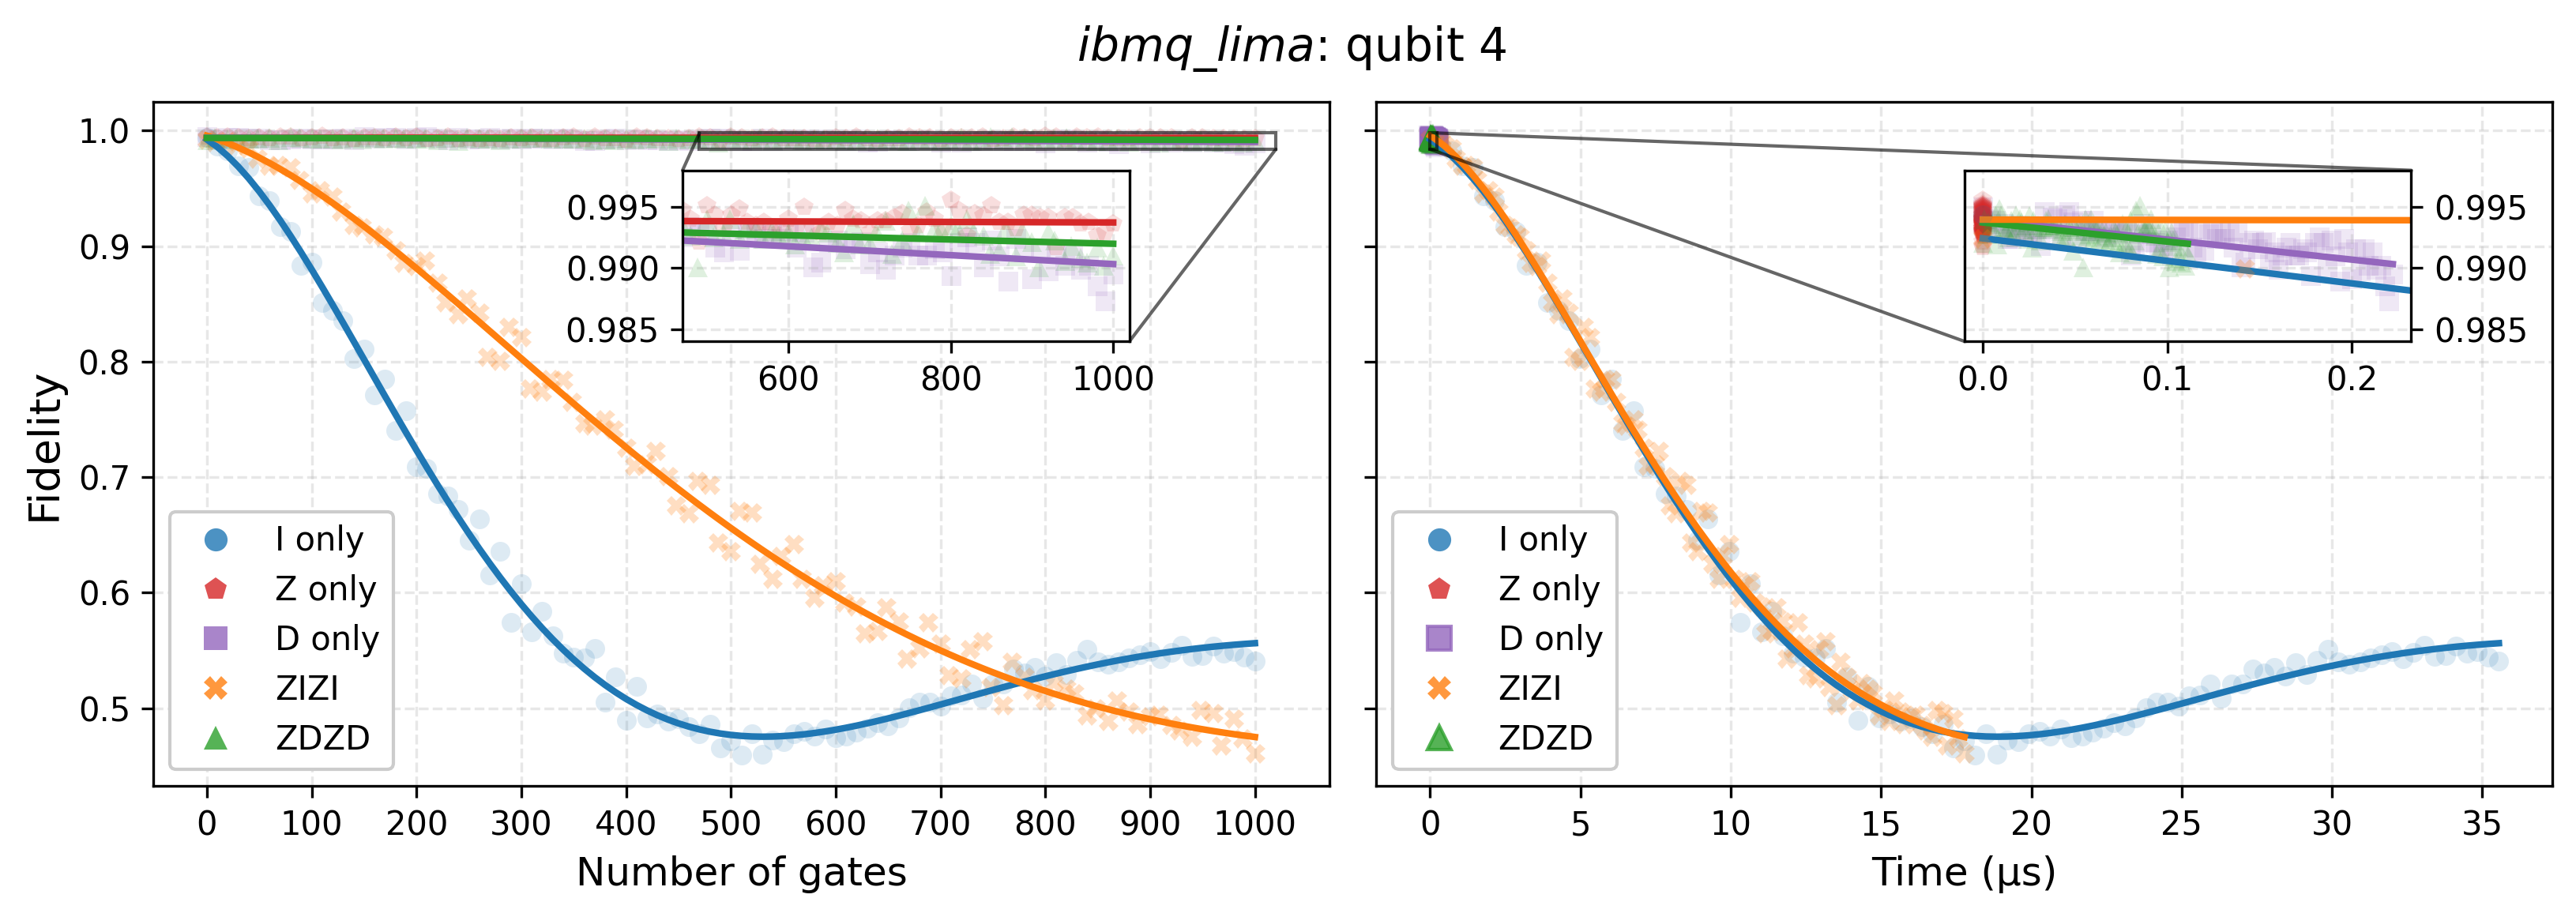

In [15]:
import copy

def line_fit(x, A, B):
    return A*x + B

def cos_ramsey(x, T, B, C, D, E):
    # https://qiskit.org/documentation/experiments/tutorials/t2ramsey_characterization.html
    return B*np.exp(-x/T)*np.cos(2*np.pi*C*x+D) + E

x      = np.arange(min_gates, max_gates+step_size, step_size)
xticks = np.arange(min_gates, max_gates+10*step_size, 10*step_size, dtype=int)
shots = 8192
a = 0.15 # Alpha
ms = 6 # Markersize
colors = ["C0", "C3", "C4", "C1", "C2"]

fig, axs = plt.subplots(ncols=2, figsize=(11,4), sharey=True, dpi=300)
fig.suptitle(r"$\it{ibmq\_%s}$: qubit 4" % "lima", y=0.955, fontsize=14)

# Number of gates plot --------------------

ax = axs[0]
ax.set_xticks(xticks)
ax.set_xlabel("Number of gates", fontsize=12)
ax.set_ylabel("Fidelity", fontsize=13)

# Plot the points
ax.plot(num_gates_list[0],np.asarray(data_I)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="I only", alpha=a, c="C0")
ax.plot(num_gates_list[1],np.asarray(data_Z)/shots, lw=0, marker="p", markersize=ms, markeredgewidth=0, label="Z only", alpha=a, c="C3")
ax.plot(num_gates_list[1],np.asarray(data_D)/shots, lw=0, marker="s", markersize=ms, markeredgewidth=0, label="D only", alpha=a, ls="--", c="C4", zorder=1)
ax.plot(num_gates_list[2],np.asarray(data_ZIZI)/shots, lw=0, marker="X", markersize=ms, markeredgewidth=0, label="ZIZI", alpha=a+0.1, ls="--", c="C1")
ax.plot(num_gates_list[3],np.asarray(data_ZDZD)/shots, lw=0, marker="^", markersize=ms, markeredgewidth=0, label="ZDZD", alpha=a, ls="--", c="C2")

# Plot the fits
fidelities = [np.asarray(data_I)/shots, 
              np.asarray(data_Z)/shots, 
              np.asarray(data_D)/shots, 
              np.asarray(data_ZIZI)/shots, 
              np.asarray(data_ZDZD)/shots]
fit_curves = []
fit_results =[]

for l, k in enumerate([0,3]):
    seq_data = fidelities[k]
    seq_num_gates = num_gates_list[[0,1,1,2,3][k]]

    if k == 3:
        seq_num_gates = seq_num_gates
        
    model = Model(cos_ramsey)
    model.set_param_hint('T', value=1000)
    model.set_param_hint('B', value=1)
    model.set_param_hint('C', value=0.0001)
    model.set_param_hint('D', value=1)
    model.set_param_hint('E', value=0.5)
    fit_result = model.fit(seq_data, x=seq_num_gates) 
    print(0, k, fit_result.params["T"],
         fit_result.params["B"],
         fit_result.params["C"],
         fit_result.params["D"],
         fit_result.params["E"])
    print(fit_result.success)
    plot_y = fit_result.best_fit
    fit_curves.append(np.copy(plot_y))
    fit_results.append(copy.copy(fit_result))
    if k==3:
        new_y = cos_ramsey(x=np.asarray(num_gates_list[[0,1,1,2,3][k]]), 
           T=fit_result.params["T"].value, 
           B=fit_result.params["B"].value, 
           C=fit_result.params["C"].value, 
           D=fit_result.params["D"].value, 
           E=fit_result.params["E"].value)
        ax.plot(num_gates_list[[0,1,1,2,3][k]], new_y, lw=2, alpha=1, ls="solid", c="C1")
    else:
        ax.plot(seq_num_gates, plot_y, lw=2, alpha=1, ls="solid", c=colors[k])
    
# Inset axes
axins = ax.inset_axes([0.45, 0.65, 0.38, 0.25])
axins.plot(num_gates_list[0],np.asarray(data_I)/shots, lw=0, marker="o", markersize=ms, markeredgewidth=0, label="I only", alpha=a, c="C0")
axins.plot(num_gates_list[1],np.asarray(data_Z)/shots, lw=0, marker="p", markersize=ms, markeredgewidth=0, label="Z only", alpha=a, c="C3")
axins.plot(num_gates_list[1],np.asarray(data_D)/shots, lw=0, marker="s", markersize=ms, markeredgewidth=0, label="D only", alpha=a, ls="--", c="C4", zorder=1)
axins.plot(num_gates_list[2],np.asarray(data_ZIZI)/shots, lw=0, marker="X", markersize=ms, markeredgewidth=0, label="ZIZI", alpha=a+0.1, ls="--", c="C1")
axins.plot(num_gates_list[3],np.asarray(data_ZDZD)/shots, lw=0, marker="^", markersize=ms, markeredgewidth=0, label="ZDZD", alpha=a, ls="--", c="C2")

# Inset fits
for k in [1,2,4]:
    seq_data = fidelities[k]
    seq_num_gates = num_gates_list[[0,1,1,2,3][k]]

    model = Model(line_fit)
    model.set_param_hint('A', value=0)
    model.set_param_hint('B', value=1)
    fit_result = model.fit(seq_data, x=seq_num_gates) 
    print(0, k,
         fit_result.params["A"],
         fit_result.params["B"])
    print()
    plot_y = fit_result.best_fit
    fit_curves.append(np.copy(plot_y))
    ax.plot(seq_num_gates, plot_y, lw=2, alpha=1, ls="solid", c=colors[k])
    axins.plot(seq_num_gates, plot_y, lw=2, alpha=1, ls="solid", c=colors[k])
    
axins.set_xlim(470, 1020)
axins.set_ylim(0.984, 0.998)
axins.grid(ls="--", alpha=0.3)
ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.6)

leg = ax.legend(loc="best", framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
    lh.set_markersize(7)
ax.grid(ls="--", alpha=0.3)

# Time plot --------------------

ax2 = axs[1]
ax2.set_xlabel("Time (μs)", fontsize=12)

# Plot the points
ax2.plot(np.asarray(num_gates_list[0])*I_duration*dt_in_s*1e6,np.asarray(data_I)/shots, 
         lw=0, marker="o", markersize=ms, label="I only", alpha=a, c="C0", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[1])*0*dt_in_s*1e6,np.asarray(data_Z)/shots, 
         lw=0, marker="p", markersize=ms, label="Z only", alpha=a, c="C3", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[1])*1*dt_in_s*1e6,np.asarray(data_D)/shots, 
         lw=0, marker="s", markersize=ms, label="D only", alpha=a, ls="--", c="C4")
ax2.plot(np.asarray(num_gates_list[2])*I_duration/2*dt_in_s*1e6,np.asarray(data_ZIZI)/shots, 
         lw=0, marker="X", markersize=ms, label="ZIZI", alpha=a+0.1, ls="--", c="C1", markeredgewidth=0)
ax2.plot(np.asarray(num_gates_list[3])*1/2*dt_in_s*1e6,np.asarray(data_ZDZD)/shots, 
         lw=0, marker="^", markersize=ms, label="ZDZD", alpha=a, ls="--", c="C2")

# Plot the fits
times = [np.asarray(num_gates_list[0])*I_duration*dt_in_s*1e6,
        np.asarray(num_gates_list[1])*0*dt_in_s*1e6,
        np.asarray(num_gates_list[1])*1*dt_in_s*1e6,
        np.asarray(num_gates_list[2])*I_duration/2*dt_in_s*1e6,
        np.asarray(num_gates_list[3])*1/2*dt_in_s*1e6]

for k in [0,3]:
    seq_data = fidelities[k]
    seq_times = times[k]

    if k == 3:
        seq_times = seq_times
        
    model = Model(cos_ramsey)
    model.set_param_hint('T', value=1000, min=0)
    model.set_param_hint('B', value=1)
    model.set_param_hint('C', value=0.05)
    model.set_param_hint('D', value=0)
    model.set_param_hint('E', value=0.5)
    fit_result = model.fit(seq_data, x=seq_times) 
    print(0, k, fit_result.params["T"], 
         fit_result.params["B"],
         fit_result.params["C"],
         fit_result.params["D"],
         fit_result.params["E"])
    print()
    plot_y = fit_result.best_fit
    fit_curves.append(np.copy(plot_y))
    if k==3:
        new_y = cos_ramsey(x=times[3], 
           T=fit_result.params["T"].value, 
           B=fit_result.params["B"].value, 
           C=fit_result.params["C"].value, 
           D=fit_result.params["D"].value, 
           E=fit_result.params["E"].value)
        ax2.plot(times[k], new_y, lw=2, alpha=1, ls="solid", c="C1")
    else:
        ax2.plot(seq_times, plot_y, lw=2, alpha=1, ls="solid", c=colors[k])
    
# Inset axes
axins = ax2.inset_axes([0.5, 0.65, 0.38, 0.25])

axins.plot(np.asarray(num_gates_list[0])*I_duration*dt_in_s*1e6,np.asarray(data_I)/shots, 
         lw=0, marker="o", markersize=ms, label="I only", alpha=a, c="C0", zorder=30, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[1])*0*dt_in_s*1e6,np.asarray(data_Z)/shots, 
         lw=0, marker="p", markersize=ms, label="Z only", alpha=a, c="C3", markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[1])*1*dt_in_s*1e6,np.asarray(data_D)/shots, 
         lw=0, marker="s", markersize=ms, label="D only", alpha=a, ls="--", c="C4", zorder=0, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[2])*I_duration/2*dt_in_s*1e6,np.asarray(data_ZIZI)/shots, 
         lw=0, marker="X", markersize=ms, label="ZIZI", alpha=a+0.1, ls="--", c="C1", zorder=30, markeredgewidth=0)
axins.plot(np.asarray(num_gates_list[3])*1/2*dt_in_s*1e6,np.asarray(data_ZDZD)/shots, 
         lw=0, marker="^", markersize=ms, label="ZDZD", alpha=a, ls="--", c="C2", markeredgewidth=0)

# Inset fits
for k in [2,4]:
    seq_data = fidelities[k]
    seq_times = times[k]

    model = Model(line_fit)
    model.set_param_hint('A', value=0)
    model.set_param_hint('B', value=1)
    fit_result = model.fit(seq_data, x=seq_times) 
    print(0, k,
         fit_result.params["A"],
         fit_result.params["B"])
    print()
    plot_y = fit_result.best_fit
    fit_curves.append(np.copy(plot_y))
    axins.plot(seq_times, plot_y, lw=2, alpha=1, ls="solid", c=colors[k])
axins.plot(times[0], fit_curves[0], lw=2, alpha=1, ls="solid", c="C0")
axins.plot(times[3], fit_curves[3], lw=2, alpha=1, ls="solid", c="C1")
    
axins.set_xlim(-0.01, np.asarray(num_gates_list[3])[-1]*1*dt_in_s*1e6+0.01)
axins.set_ylim(0.984, 0.998)
axins.yaxis.tick_right()
axins.grid(ls="--", alpha=0.3)
ax2.indicate_inset_zoom(axins, edgecolor="black", alpha=0.6)

leg = ax2.legend(loc="lower left", framealpha=1)
for lh in leg.legendHandles: 
    lh.set_alpha(0.8)
    lh.set_markersize(7)
ax2.grid(ls="--", alpha=0.3)

plt.tight_layout()
plt.show()
#plt.savefig(r"lima_numGates_time_q4_12082022_fit.pdf")